In [1]:
# Imports and initialization
%pylab inline

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
import inspect
import pickle
import imp
import re
import json
from scipy.optimize import curve_fit

# from IPython.html import widgets
# from IPython.display import display
# from IPython.html.widgets import interact, interactive, fixed


import thulium_python_lib.usefull_functions as usfuncs
import thulium_python_lib.image_processing_new as impr

import ipyparallel as ipp
ipp.CompositeError.tb_limit = 1

rc1 = ipp.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
dview['par_dir'] = par_dir
# with dview.sync_imports():
#     import sys, os    
%px import sys, os
%px if par_dir not in sys.path: sys.path.append(par_dir)
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from ipyparallel import bind_kernel; bind_kernel()

Populating the interactive namespace from numpy and matplotlib
Done importing, module image_processing now


In [ ]:
# to reload library on remote and local engine
# %px imp.reload(impr)
# imp.reload(impr)
# imp.reload(usfuncs)

### And now:
###### Constract loader and averager. For available parameters see help('instance')

In [7]:
loader  = impr.Load_Image(dview)
averager = impr.Avr_Image(dview,do_sifting=False)

#### Choose working directory and measurement folder

In [22]:
# smth like 'D:\!Data\2015_08_20' for lab and like '/Users/artemgolovizin/Downloads/2015_08_20' for mac
os.chdir(r'\\BIGONE\!Data\2015_12_08')
# print('Current directory', os.getcwd());

# Create folder 'Figures' for saving individual plot
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print('Folder Figures has been created')
    
working_directory = ''
folder = ''

In [36]:
folder = '17 power=6W depth=0.25/'
working_directory = os.path.join(os.getcwd(),folder)
# print('Working directory', working_directory)

dirs = [x for x in os.listdir() if re.match('\d',x)]
x_lbl, y_lbl, xaxis_calib = impr.get_x_calibration(folder, dirs)

### Load data, rearange, average and calibrate

In [37]:
# downloading images
all_data = loader(working_directory,lview)

# rearranging to dictionary
dataD = impr.rearrange_data(all_data)

# sifting(filtering) data - removing empty images  !!! DOES NOTE WORKS NOW
#impr.sift(dataD)

 150/150 tasks finished after    0 s
done

Total number of images:  150
Rearranging to dictionary is complited


In [38]:
# averaging data
avr_dataD = averager(dataD,lview)

# construct new data dictionary without image and calibration atoms number, size and x-axis
navrD = impr.mod_avrData(avr_dataD, xaxis_calib, impr.N_atoms(width=0.5, delta = 5), impr.real_size)


# for plotting sifted image

#imshow(imread('1 от частоты амплитудной модуляции аома верди (5) 3.9W/26ms/2_1.png'))
#colorbar()

  30/30 tasks finished after    0 s
done



### Construct data based on measurement type and plot

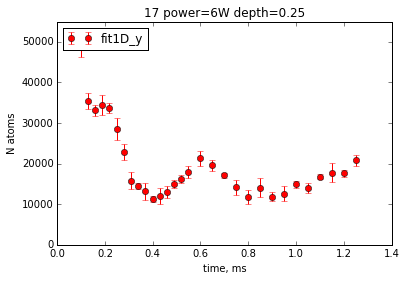

In [39]:
# find measurement type to automatically plot needed data
meas_type = re.findall('\d+\s+(\w+)',folder)
meas_type = 'LT' if len(meas_type) ==0 else meas_type[0].upper()

# shot_typeN - for now only 1, if there will be calibration - 1 or more
shot_typeN = 1

# description to add to all_data.txt file
description = dict()
description['meas_type'] = meas_type
description['x_label'] = x_lbl
description['y_label'] = y_lbl

#meas_type = 'T' # here one can specify type to get desired plots
# meas_type = 'T'
fit_func = None
fig1, ax1 = subplots()
if meas_type == 'T':
    # construct data with cloud expansion on both coordinates
    # first set of data  - Temperature X
    d1 = impr.get_avr_data(navrD, shot_typeN, 'fit1D_x',2)
    d1['fmt']='ro'
    d1['label']='fit1D_x'
    #impr.drop_by_number(d1,5)
    #impr.drop_by_x(d1,130,160)

    # second set of data  - Temperature Y
    d2 = impr.get_avr_data(navrD, shot_typeN,  'fit1D_y',2)
    d2['fmt']='bo'
    d2['label'] = 'fit1D_y'
    #impr.drop_by_number(d2,5)
    
    # fit cloud expansion
    fit_func = usfuncs.cloud_expansion0
    popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0],20))
    popt_T2, pcov_T2 = curve_fit(fit_func, d2['x'], d2['y'], p0=(d2['y'][0], 20))
    print('Fit parameters X, Y:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,popt_T2))))
    
    # plot data and fits  ADD T VALUE ON PLOT
    ax1.errorbar(**d2)
    ax1.errorbar(**d1)
    ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),'k', label='Tx=%.2f'%(popt_T[0]))
    ax1.plot(linspace(min(d2['x']),max(d2['x']),100), fit_func(linspace(min(d2['x']),max(d2['x']),100),*popt_T2),'k', label='Ty=%.2f'%(popt_T2[0]))
    ax1.set_xlim(min(d1['x'])-1, max(d1['x'])+1)
    # add information about fits to description
    description['fit1D_x'] =  popt_T
    description['fit1D_y'] =  popt_T2
    description['fit-function'] = fit_func.__name__
else:
    # construct data, param - what value to use
    param = 'fit1D_y'
    d1 = impr.get_avr_data(navrD, shot_typeN, param, 0)
    d1['fmt']='ro'
    d1['label']=param
    #impr.drop_by_number(d1,*range(20,len(d1['x'])))
    #impr.drop_by_x(d1,130,160)
    
    # fit_func - which function to use to fit data  here one can put conditions on meas_type to choose fit
    popt_T = None
#     fit_func = usfuncs.exp_decay
#     popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0], 100,0))
#     #popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(-d1['y'][0], d1['x'][argmin(d1['y'])],0.1,d1['y'][0]))
#     print('Fit parameters:\n' + usfuncs.construct_fit_description(fit_func, popt_T))
    
    # plot data and fits
    ax1.errorbar(**d1)
    if fit_func != None:
        ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),'k', label='fit X')
    if fit_func != None:
        fit_label = fit_func.__name__ + ' fit:\n' + usfuncs.construct_fit_description(fit_func, popt_T)
        ax1.text(0.01,0.01,fit_label,transform=ax1.transAxes)
        description['fit'] =  popt_T
        description['fit-function'] = fit_func.__name__
    

ax1.set_xlabel(x_lbl)
ax1.set_ylabel(y_lbl)
ax1.set_title(folder.rstrip(r'\/ '))
ax1.set_ylim(bottom=0)
ax1.legend(loc=2)

<Container object of 3 artists>

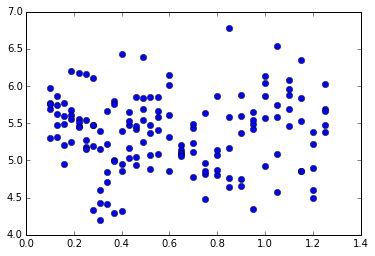

In [40]:
# for each picture
d3 = dict()
d3['x'],d3['y'] = impr.constract_data(dataD, shot_typeN, 'fit1D_y',2)

fig2, ax2 = subplots()
ax2.errorbar(fmt='o',**d3)



In [41]:
# show 2D image
# imshow(avr_dataD[0.2][1].image)

In [42]:
if folder != '':
    fig1.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'.png'))
    try:
        with open('all_data.txt', 'rb') as handle:
            res_dict = pickle.loads(handle.read())
    except FileNotFoundError:
        res_dict = {}
    except EOFError:
        res_dict = {}
    res_dict[folder.rstrip(r'\/ ')]={'description':description,'data':navrD}
    with open('all_data.txt', 'wb') as handle:
        pickle.dump(res_dict, handle)
    with open('all_data.json', 'w') as outfile:
        json.dump(res_dict, outfile, cls=impr.JsonCustomEncoder, indent=4)    
    print('Figure and data saved!!!')
    
# to later read json file run following two lines
#with open('all_data.json', 'r') as infile:
#        ddata = json.load(infile)

Figure and data saved!!!


In [43]:
# to check how good is fit
perr = np.sqrt(np.diag(pcov_T))
print(perr)

[ 0.6520586   7.15630182]


C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


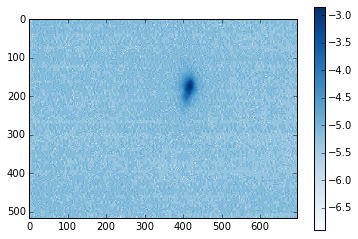

In [44]:
#innn = (imread('image144211.jpg')[:,:,0]-66) / 1e3
imshow(log(innn),cmap='Blues')
colorbar()

In [33]:
amin(innn)

1

C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


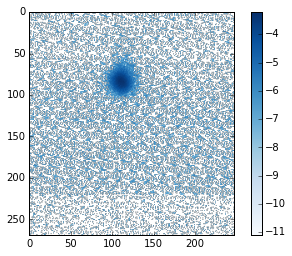

In [48]:
#immm = imread('1_1.png')
imshow(log(immm),cmap='Blues')
colorbar()

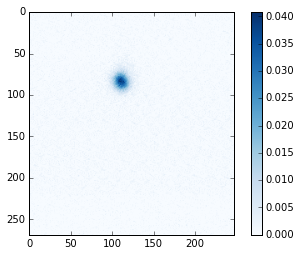

In [40]:
imshow(immm,cmap='Blues')
colorbar()